<a href="https://colab.research.google.com/github/kmouleejunhyuk/titanic_review/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##캐글의 타이타닉 분석 리뷰
#리더보드 정확도 100% 전처리 기법 사용
#원본: https://www.kaggle.com/imoore/titanic-the-only-notebook-you-need-to-see
#추가로, 다층 FCNN 모델+kfold 구현 연습

In [2]:
#환경
#google colab, pytorch

In [3]:
#구글 드라이브 마운트 & 경로설정
#마운트하기 전, 구글 드라이브의 titanic 폴더에 타이타닉 csv를 업로드해야 합니다
#kaggle 가입 후 데이터를 받을 수 있습니다

from google.colab import drive
drive.mount('/gdrive')

PATH='/gdrive/My Drive/titanic'

Mounted at /gdrive


라이브러리 로드

In [4]:
import pandas as pd
import numpy as np
import re
import os

import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import torch

데이터 로드

In [5]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

passengerid=test['PassengerId'].ravel()

In [6]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [7]:
print(train.head())
print(test.head())

print(train.columns)

   PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]
   PassengerId  Pclass  ... Cabin Embarked
0          892       3  ...   NaN        Q
1          893       3  ...   NaN        S
2          894       2  ...   NaN        Q
3          895       3  ...   NaN        S
4          896       3  ...   NaN        S

[5 rows x 11 columns]
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


데이터에 ticket_type라는 변수 추가(이유는 잘 모르겠다)


In [8]:
#원본에서는 pd.DataFrame.apply()를 사용했지만, 속도 개선을 위해 np.vectorize() 사용
train['Ticket_type']=np.vectorize(lambda x: x[0:3])(train['Ticket'])
train['Ticket_type']=train['Ticket_type'].astype('category')
train['Ticket_type']=train['Ticket_type'].cat.codes

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,124
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,137
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,148


In [9]:
test['Ticket_type']=np.vectorize(lambda x: x[0:3])(test['Ticket'])
test['Ticket_type']=test['Ticket_type'].astype('category')
test['Ticket_type']=test['Ticket_type'].cat.codes

test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,58
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,71
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,32


데이터에 이름 길이에 관한 변수 추가

In [10]:
train['Word_count']=np.vectorize(lambda x: len(x.split()))(train['Name'])
test['Word_count']=np.vectorize(lambda x: len(x.split()))(test['Name'])

Cabin 호수 별 변수 추가

In [11]:
#A30-->A-->0
#커스텀
train['Cabin_class']=np.vectorize(lambda x: x[0] if type(x)!=float else 'P')(train['Cabin'])
train['Cabin_class']=train['Cabin_class'].astype('category').cat.codes
test['Cabin_class']=np.vectorize(lambda x: x[0] if type(x)!=float else 'P')(test['Cabin'])
test['Cabin_class']=test['Cabin_class'].astype('category').cat.codes

승객의 선실 보유 여부를 알려주는 변수 추가(nan-->입석?)

In [12]:
train['Has_Cabin']=np.vectorize(lambda x: 0 if type(x)==float else 1)(train['Cabin'])
test['Has_Cabin']=np.vectorize(lambda x: 0 if type(x)==float else 1)(test['Cabin'])

승객의 동승자 수 및 단독 승선 여부 변수 추가

In [13]:
train['Family_size']=train['SibSp'] + train['Parch'] + 1
test['Family_size']=test['SibSp'] + test['Parch'] + 1

In [14]:
train['isalone']=np.vectorize(lambda x: 0 if x>1 else 1)(train['Family_size'])
test['isalone']=np.vectorize(lambda x: 0 if x>1 else 1)(test['Family_size'])

Embarked 변수의 na 제거

In [15]:
train['Embarked']=train['Embarked'].fillna('S')
test['Embarked']=test['Embarked'].fillna('S')

표 가격(Fare)의 중위수로 na 대체 

In [16]:
train['Fare']=train['Fare'].fillna(train['Fare'].median())
test['Fare']=test['Fare'].fillna(test['Fare'].median())

#원본에서는 categoricalfare라는 변수를 만들지만 사용하지 않음

In [17]:
full_data=[train, test]

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



이름에서 mrs, ms등의 의미를 가진 문자를 변수로 생성

In [18]:
def get_title(name):
    title_search=re.search(' ([A-Za-z]+)\.', name)
    if title_search: return title_search.group(1)
    return ""

In [19]:
train['Title']=np.vectorize(get_title)(train['Name'])
test['Title']=np.vectorize(get_title)(test['Name'])

In [20]:
def replace_names(dataset: pd.DataFrame):
    #필요에 따라 확장할 수 있게 함수로 표현
    #오타, 비정형 표현을 변형
    replace_to_rare=['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    replace_by_rule={'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}

    dataset['Title'] = dataset['Title'].replace(replace_to_rare, 'Rare')
    for key, value in replace_by_rule.items():
        dataset['Title'] = dataset['Title'].replace(key, value)
    return None

In [21]:
replace_names(train)
replace_names(test)

Sex, title, fare, embarked, age를 숫자로 매핑

In [22]:
def is_categorical(column, a=train, b=test):
    #카테고리인지 확인
    if np.array_equal(np.unique(a[column].values), np.unique(b[column].values)) & len(np.unique(a[column].values))<30:
        return True
    return False

def mapper(dataset, column):
    map_dict={}
    for idx, key in enumerate(np.unique(dataset[column].values)):
        map_dict[key]=idx

    dataset[column]=dataset[column].map(map_dict).astype(int)

In [23]:
import sys
def range_mapper(dataset, column, c_range: list):
    c_range.insert(0, float('-inf'))
    c_range.append(float('inf'))
    for idx in range(len(c_range)-1):
        dataset.loc[(dataset[column]>c_range[idx]) & (dataset[column]<=c_range[idx+1]), column] = idx
    dataset[column] = dataset[column].astype(int)

In [24]:
if is_categorical('Sex'): 
    mapper(train, 'Sex')
    mapper(test, 'Sex')

if is_categorical('Title'): 
    mapper(train, 'Title')
    mapper(test, 'Title')

if is_categorical('Embarked'): 
    mapper(train, 'Embarked')
    mapper(test, 'Embarked')

In [25]:
range_mapper(train, 'Fare', [7.91, 14.454, 31])
range_mapper(test, 'Fare', [7.91, 14.454, 31])

range_mapper(train, 'Age', [16, 32, 48, 64])
range_mapper(test, 'Age', [16, 32, 48, 64])

사용할 컬럼 외에는 제거한다(Feature_selection)

In [26]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1).astype('int')
test  = test.drop(drop_elements, axis = 1).astype('int')

In [27]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Word_count,Cabin_class,Has_Cabin,Family_size,isalone,Title
0,0,3,1,1,0,0,2,124,4,7,0,2,0,2
1,1,1,0,2,0,3,0,137,7,2,1,2,0,3
2,1,3,0,1,0,1,2,148,3,7,0,1,1,1
3,1,1,0,2,0,3,2,3,7,2,1,2,0,3
4,0,3,1,2,0,1,2,97,4,7,0,1,1,2


In [28]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Word_count,Cabin_class,Has_Cabin,Family_size,isalone,Title
0,3,1,2,0,0,1,58,3,7,0,1,1,2
1,3,0,2,0,0,2,71,5,7,0,2,0,3
2,2,1,3,0,1,1,32,4,7,0,1,1,2
3,3,1,1,0,1,2,55,3,7,0,1,1,2
4,3,0,1,1,1,2,54,6,7,0,3,0,3


피어슨 상관계수 시각화

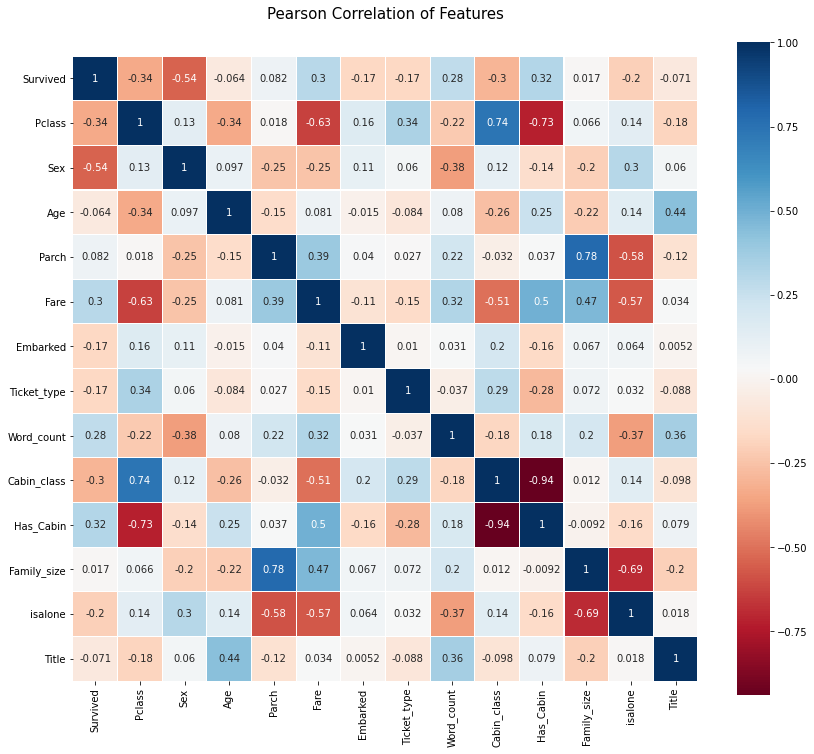

In [29]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [30]:
#has_cabin과 cabin_class가 너무 강하게 연관됨. 개선이 필요
#전처리 끝

In [31]:
train.values.shape

(891, 14)

In [49]:
#maximum={}
#for _ in train.columns:
#    m=max(train[_])
#    maximum[_]=m
#    train[_]=train[_]/m

In [50]:
train

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Word_count,Cabin_class,Has_Cabin,Family_size,isalone,Title
0,0.0,1.000000,1.0,0.25,0.0,0.000000,1.0,0.810458,0.285714,0.875,0.0,0.181818,0.0,0.50
1,1.0,0.333333,0.0,0.50,0.0,1.000000,0.0,0.895425,0.500000,0.250,1.0,0.181818,0.0,0.75
2,1.0,1.000000,0.0,0.25,0.0,0.333333,1.0,0.967320,0.214286,0.875,0.0,0.090909,1.0,0.25
3,1.0,0.333333,0.0,0.50,0.0,1.000000,1.0,0.019608,0.500000,0.250,1.0,0.181818,0.0,0.75
4,0.0,1.000000,1.0,0.50,0.0,0.333333,1.0,0.633987,0.285714,0.875,0.0,0.090909,1.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,0.0,1.000000,1.0,0.25,0.0,0.000000,1.0,0.542484,0.214286,0.875,0.0,0.090909,1.0,0.50
567,0.0,1.000000,0.0,0.25,0.8,0.666667,1.0,0.542484,0.428571,0.875,0.0,0.454545,0.0,0.75
568,0.0,1.000000,1.0,0.50,0.0,0.000000,0.0,0.339869,0.214286,0.875,0.0,0.090909,1.0,0.50
569,1.0,1.000000,1.0,0.25,0.0,0.000000,1.0,0.549020,0.214286,0.875,0.0,0.090909,1.0,0.50


In [51]:
#for _, m in zip(valid.columns, maximum):
#    valid[_]=valid[_]/m


In [52]:
valid

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Word_count,Cabin_class,Has_Cabin,Family_size,isalone,Title
570,1.0,0.666667,1.0,0.75,0.0,0.333333,1.0,0.928105,0.214286,0.875,0.0,0.090909,1.0,0.50
571,1.0,0.333333,0.0,0.75,0.0,1.000000,1.0,0.032680,0.428571,0.250,1.0,0.272727,0.0,0.75
572,1.0,0.333333,1.0,0.50,0.0,0.666667,1.0,0.895425,0.357143,0.500,1.0,0.090909,1.0,0.50
573,1.0,1.000000,0.0,0.25,0.0,0.000000,0.5,0.091503,0.214286,0.875,0.0,0.090909,1.0,0.25
574,0.0,1.000000,1.0,0.00,0.0,0.333333,1.0,0.803922,0.357143,0.875,0.0,0.090909,1.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,1.0,0.333333,0.0,0.25,0.0,1.000000,1.0,0.019608,0.214286,0.875,0.0,0.090909,1.0,0.25
709,1.0,1.000000,1.0,0.25,0.2,0.666667,0.0,0.326797,0.428571,0.875,0.0,0.272727,0.0,0.00
710,1.0,0.333333,0.0,0.25,0.0,1.000000,0.0,0.895425,0.500000,0.250,1.0,0.090909,1.0,0.25
711,0.0,0.333333,1.0,0.50,0.0,0.666667,1.0,0.019608,0.214286,0.250,1.0,0.090909,1.0,0.50


분류 신경망 정의하기

In [71]:
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1=torch.nn.Linear(13, 512)
        self.fc2=torch.nn.Linear(512, 64)
        self.fc3=torch.nn.Linear(64, 2)

    def forward(self, x):
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc2(x)
        x=F.relu(x)
        x=self.fc3(x)
        x=torch.sigmoid(x)

        return x

model=Net()

In [72]:
num_epoch=20

In [73]:
origin=train.copy()
train=origin.loc[:int(origin.shape[0]*0.8)].copy()
valid=origin.loc[int(origin.shape[0]*0.8):].copy()
test['Survived']=0

In [74]:
x_train=train.loc[:, train.columns != 'Survived'].values
y_train=train['Survived'].values

x_valid=valid.loc[:, valid.columns != 'Survived'].values
y_valid=valid['Survived'].values

x_test=test.loc[:, test.columns != 'Survived'].values
y_test=test['Survived']

In [75]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [76]:
#accuracy 계산 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [77]:
from sklearn.utils import shuffle
from torch.autograd import Variable

for epoch in range(100):
    print('Epoch {}'.format(epoch+1))

    model.train()
    x_var = Variable(torch.FloatTensor(x_train))
    y_var = Variable(torch.LongTensor(y_train))
    # Forward + Backward + Optimize
    #optimizer.zero_grad()
    train_pred = model(x_var)
    loss =criterion(train_pred, y_var)
    loss.backward()
    optimizer.step()
    train_acc=calc_accuracy(train_pred, y_var)
    print('train: ', loss.data.numpy(), train_acc)

    valid_pred=model(Variable(torch.FloatTensor(x_valid)))
    valid_loss=criterion(valid_pred, Variable(torch.LongTensor(y_valid)))
    valid_acc=calc_accuracy(valid_pred, Variable(torch.LongTensor(y_valid)))
    print('valid:  ', valid_loss.data.numpy(), valid_acc)

Epoch 1
train:  0.70034873 0.34893617021276596
valid:   0.6577086 0.5932203389830508
Epoch 2
train:  0.6312981 0.6510638297872341
valid:   0.68513435 0.5932203389830508
Epoch 3
train:  0.6315921 0.6510638297872341
valid:   0.69469965 0.5932203389830508
Epoch 4
train:  0.63953716 0.6510638297872341
valid:   0.6518721 0.6101694915254238
Epoch 5
train:  0.6029895 0.6893617021276596
valid:   0.5624224 0.7966101694915254
Epoch 6
train:  0.5326434 0.7489361702127659
valid:   0.6530589 0.6610169491525424
Epoch 7
train:  0.6133676 0.7489361702127659
valid:   0.73304373 0.5254237288135594
Epoch 8
train:  0.72439605 0.5106382978723404
valid:   0.6510688 0.6610169491525424
Epoch 9
train:  0.5722229 0.7617021276595745
valid:   0.5718093 0.711864406779661
Epoch 10
train:  0.52696997 0.7617021276595745
valid:   0.6094679 0.6610169491525424
Epoch 11
train:  0.5718776 0.7276595744680852
valid:   0.6510809 0.6779661016949152
Epoch 12
train:  0.5975966 0.7148936170212766
valid:   0.6959005 0.61016949152

In [ ]:
#XGDBOOST with ensemble

In [78]:
import sklearn
import xgboost as xgb

In [83]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators= 2000,
    max_depth= 4,
    min_child_weight= 2,
    #gamma=1,
    gamma=0.9,                        
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1).fit(x_train, y_train)
    
xgb_predictions = gbm.predict(x_test)

In [93]:
valid_pred_xgb = gbm.predict(x_valid)

sum_correct=0
for a, b in zip(valid_pred_xgb, y_valid):
    if a==b: 
        sum_correct=sum_correct+1

acc=sum_correct/y_valid.shape[0]
print(acc)


0.7457627118644068


In [86]:
StackingSubmission = pd.DataFrame({ 'PassengerId': passengerid,
                            'Survived': xgb_predictions })

In [87]:
StackingSubmission

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0
...,...,...
413,1305,0.0
414,1306,0.0
415,1307,0.0
416,1308,0.0
